## Markdown

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Read the 'data.csv' file and create a dataframe 'df'

In [2]:
data_filename = pd.read_csv('data2.csv')
df = pd.DataFrame(data_filename)

#### Check the distribution of the observations of COVID-19 case rate in cities of England in the winter of 2020.

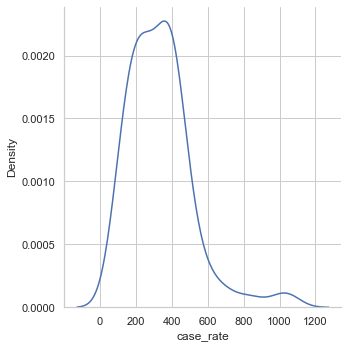

In [3]:
sns.displot(df, x = 'case_rate', kind="kde")
plt.savefig('case_rate')

As the plot is heavily right-tailed (positively skewed), we apply a log-linear model in the analysis where the new dependent variable is the natural logarithm of the observations of COVID-19 case rate in local authority area i of England

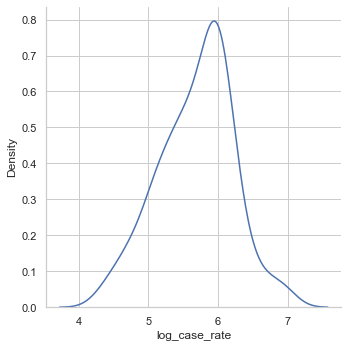

In [4]:
sns.displot(df, x = 'log_case_rate', kind="kde")
plt.savefig('log_case_rate')

The second plot looks more similar to normal distirbution.

#### Check the outliers of the observations (COVID-19 case rate in city i of England in month j)

In [5]:
case_rate= df['log_case_rate']
Q1 =  case_rate.quantile(0.25)
Q3 = case_rate.quantile(0.75)
IQR = Q3 - Q1


case_rate_outliers = df['Lower Tier Local Authority'][(df['log_case_rate'] < Q1-1.5*IQR ) | (df['log_case_rate'] > Q3+1.5*IQR)]

case_rate_no_outliers = df['Lower Tier Local Authority'][(df['log_case_rate'] > Q1-1.5*IQR ) | (df['log_case_rate'] < Q3+1.5*IQR)]

case_rate_outliers

Series([], Name: Lower Tier Local Authority, dtype: object)

#### Draw the boxplot to visualize the distribution of 'log(case_rate)'

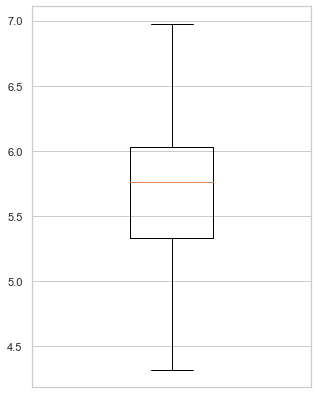

In [6]:
output_filename = 'boxplot'
figure_width, figure_height = 5,7
plt.figure(figsize=(figure_width,figure_height))
plt.xlim([0.75,1.25])
plt.xticks([])
plt.boxplot(np.log(df['case_rate']), manage_ticks=(False))
plt.savefig(output_filename)

No outliers in the values of 'log(case_rate)'

### ANCOVA model

In [7]:
# Create dummy variables for time and region variables
Month = pd.get_dummies(df['month'])
Month = Month[['November','December']]

Region = pd.get_dummies(df['region'])
Region = Region[['East of England','North East', 'North West', 'South East', 'South West', 'East Midlands', 'West Midlands','Yorkshire and the Humber']]
# Create the variables for climate features: 'precipitation','humidity' and 'temp'
x_values = df[['precipitation','humidity','temperature','population_density']]

# Combine the variables for climate features with dummy variables for time and region variables
x_values = pd.concat([x_values, Month, Region], axis=1, sort=False)

# Create the dependent variable
y_values = df['log_case_rate']

#### Firstly check the correlation between independent variables by a heat map)

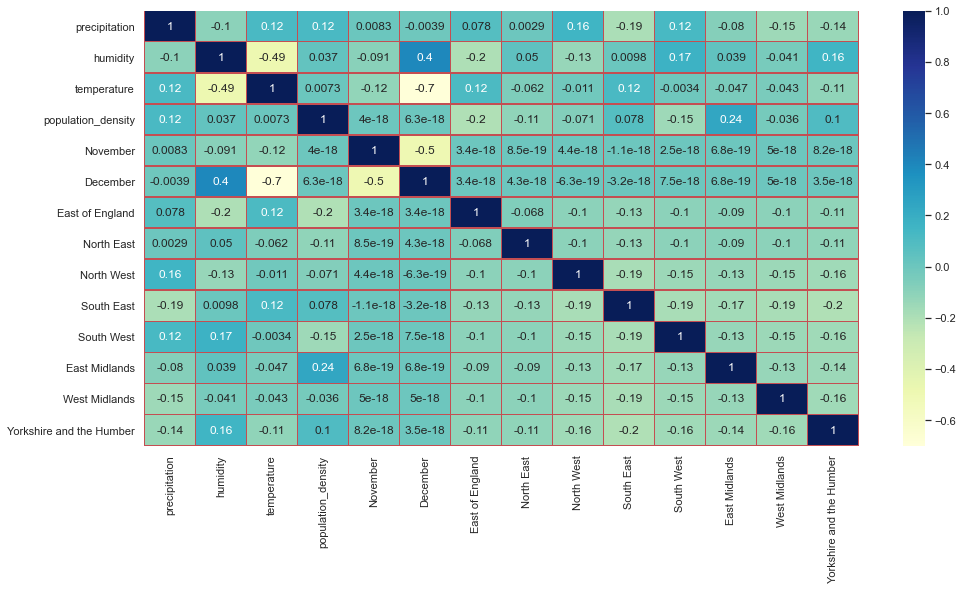

In [8]:
fig = plt.figure(figsize=(16,8))
sns.heatmap(x_values.corr(),annot = True,cmap='YlGnBu', linecolor='r',linewidth=0.5)
output_filename = 'correlation matrix'
plt.savefig(output_filename)

As the correlations between the dummy variable 'December' and the variable of temperature is larger than 0.05, we cannot assume that multicollinearity doesn't exist.
Hence, we remove the dummy variable 'December' from the model.

                            OLS Regression Results                            
Dep. Variable:          log_case_rate   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     4.430
Date:                Tue, 19 Jan 2021   Prob (F-statistic):           3.68e-06
Time:                        03:46:25   Log-Likelihood:                -84.746
No. Observations:                 141   AIC:                             197.5
Df Residuals:                     127   BIC:                             238.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<AxesSubplot:>

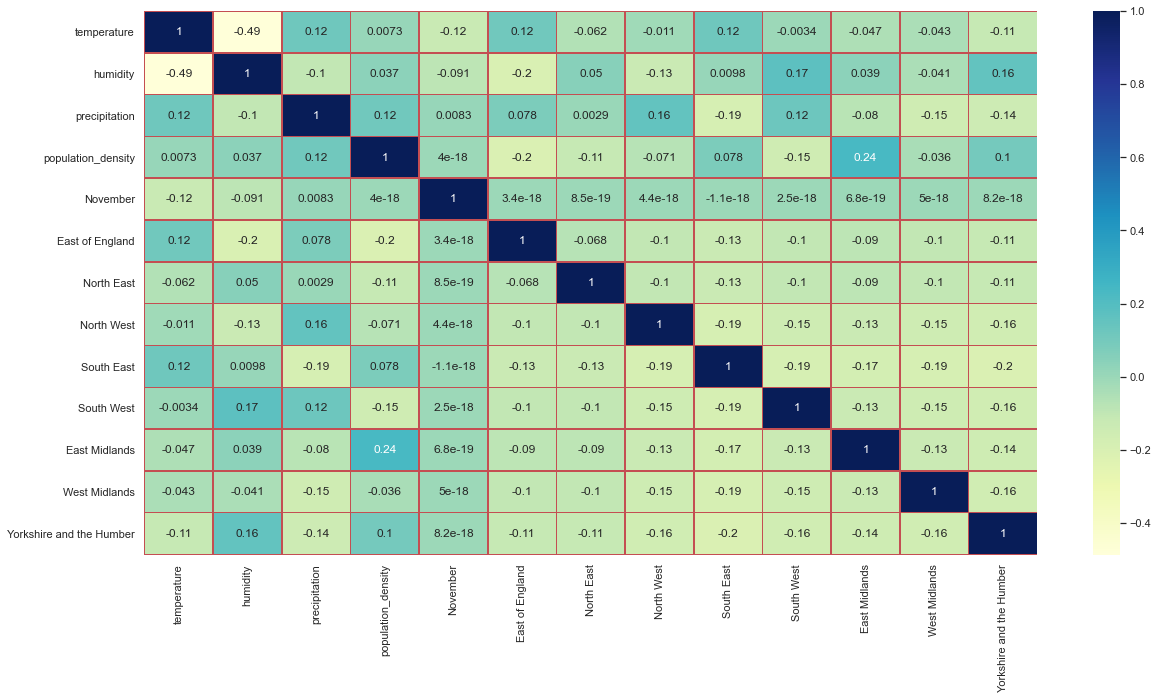

In [9]:
# Create dummy variables for time and region variables and remove variables for 'December'
Month = pd.get_dummies(df['month'])
Month = Month['November']

Region = pd.get_dummies(df['region'])
Region = Region[['East of England','North East','North West','South East','South West','East Midlands','West Midlands','Yorkshire and the Humber']]

x_values = df[['temperature', 'humidity','precipitation','population_density']]
x_values = pd.concat([x_values, Month, Region], axis=1, sort=False)

# Create the dependent variable
y_values = df['log_case_rate']

X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)

regression_model_b = regression_model_a.fit()

# Print a summary of the results:
print(regression_model_b.summary())

fig = plt.figure(figsize=(20,10))
sns.heatmap(x_values.corr(),annot = True,cmap='YlGnBu', linecolor='r',linewidth=0.5)


#### Check the model fitness by residuals vs fitted plot:

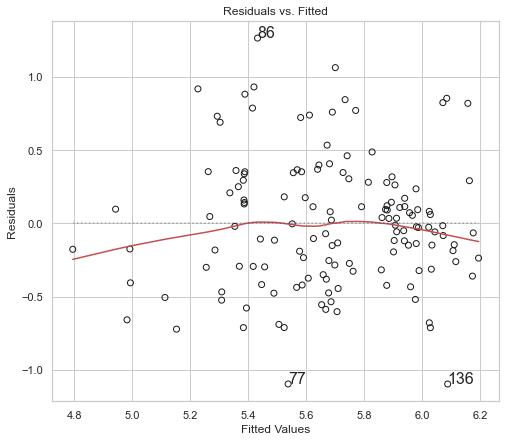

In [10]:
residuals = regression_model_b.resid
fitted = regression_model_b.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()